<a href="https://colab.research.google.com/github/Vrushti-kulkarni/RAG/blob/main/FirstRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip langchain

ERROR: unknown command "langchain"


dataset and libraries

In [ ]:
from tqdm.notebook import tqdm #library used to display progress bars in loops
import pandas as pd
from typing import Optional, List, Tuple #Code clarity and correctness
# from datasets import Dataset (hugging face library)
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

# **Knowledge Base**

In [ ]:
!pip install PyPDF2

In [ ]:
from PyPDF2 import PdfReader

reader = PdfReader("/content/RAG_pdf.pdf")

documents = []
for i, page in enumerate(reader.pages):
    text = page.extract_text()
    documents.append({
        "text": text,
        "source": f"page_{i+1}"
    })

In [ ]:
documents[0]

{'text': 'Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewisyz, Ethan Perez?,\nAleksandra Piktusy, Fabio Petroniy, Vladimir Karpukhiny, Naman Goyaly, Heinrich Küttlery,\nMike Lewisy, Wen-tau Yihy, Tim Rocktäschelyz, Sebastian Riedelyz, Douwe Kielay\nyFacebook AI Research;zUniversity College London;?New York University;\nplewis@fb.com\nAbstract\nLarge pre-trained language models have been shown to store factual knowledge\nin their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-\nstream NLP tasks. However, their ability to access and precisely manipulate knowl-\nedge is still limited, and hence on knowledge-intensive tasks, their performance\nlags behind task-speciﬁc architectures. Additionally, providing provenance for their\ndecisions and updating their world knowledge remain open research problems. Pre-\ntrained models with a differentiable access mechanism to explicit non-parametric\nmemory have so far been only investigated for 

In [ ]:
from langchain.docstore.document import Document as LangchainDocument #renaming for better use

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(documents)
]

  0%|          | 0/19 [00:00<?, ?it/s]

# **1. Retriever**       

*   top k snippet
*   lost in the middle phenomenon
*   not too big size of retrieved snippets



      



### 1.1 Split to chunks

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

check chunk size < embedding models maximum sequence length

###1.2 embedding

In [ ]:
pip install sentence_transformers langchain-community

In [ ]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

Model's maximum sequence length: 512


In [ ]:
#Model's maximum sequence length: 512

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)] #lengths becomes a list of token lengths for each document

  0%|          | 0/88 [00:00<?, ?it/s]

optional plot

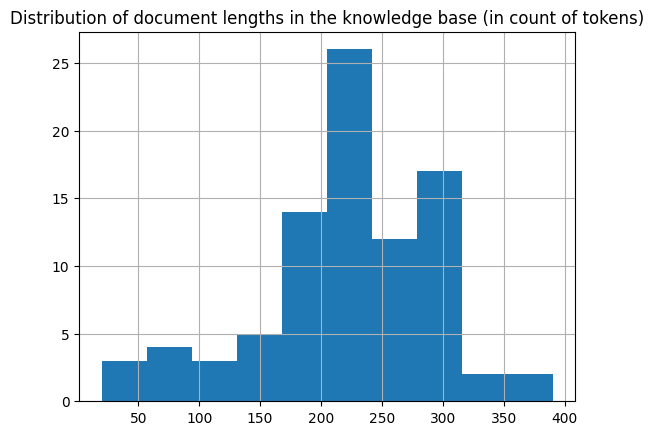

In [ ]:
# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

***the chunk lengths are not aligned with our limit of 512 tokens***

this can be read as, bins go from 0-50, 50-100 so on


                                  
hence from 0-50 there are approximately 3 chunks,
from 50-100 there are approximately 4 chunks and so on



In [ ]:
#total number of chunks
print("Total number of chunks:", len(docs_processed))


Total number of chunks: 88


##**using final_doc_1 without further chunking as token lengths are already less than 512 for all chunks**




In [ ]:
final_doc_1 = docs_processed

##**using final_doc with further chunking**

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer


EMBEDDING_MODEL_NAME = "thenlper/gte-small"

#here for example knowledge_base is the variable name, and the value the variable expects is type List made of LangchainDocument
def split_documents(chunk_size: int, knowledge_base: List[LangchainDocument], tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]: #this is a return type hint
      #An optional argument, If not provided, it defaults to the value of the variable EMBEDDING_MODEL_NAME (which is "thenlper/gte-small" in your case)
      text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

      #new processed doc
      docs_processed_1 = []
      for doc in knowledge_base:
          docs_processed_1 += text_splitter.split_documents([doc])

      # Remove duplicates
      unique_texts = {}
      docs_processed_unique = []
      for doc in docs_processed_1:
          if doc.page_content not in unique_texts:
              unique_texts[doc.page_content] = True
              docs_processed_unique.append(doc)

      return docs_processed_unique


docs_processed_1 = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

  0%|          | 0/88 [00:00<?, ?it/s]

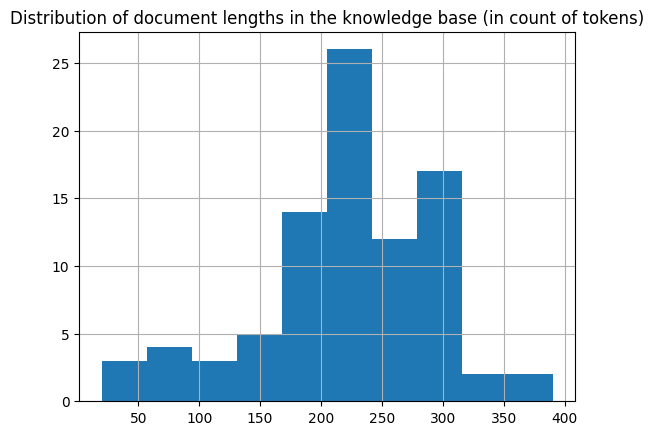

In [ ]:
# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths_1 = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths_1).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

##1.3 Building vector database

 to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

In [ ]:
pip install faiss-cpu

In [ ]:
#with normal chunked data
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

#with further chunked data
KNOWLEDGE_VECTOR_DATABASE_1 = FAISS.from_documents(
    docs_processed_1, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
user_query = "What is RAG?"

In [ ]:
#DATABASE 1
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What is RAG?'...

==================================Top document==================================
1Code to run experiments with RAG has been open-sourced as part of the HuggingFace Transform-
ers Library [ 66] and can be found at https://github.com/huggingface/transformers/blob/master/
examples/rag/ . An interactive demo of RAG models can be found at https://huggingface.co/rag/
2
==================================Metadata==================================
{'source': 'page_2', 'start_index': 4280}


In [ ]:
#DATABASE 2
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs_1 = KNOWLEDGE_VECTOR_DATABASE_1.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs_1[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs_1[0].metadata)


Starting retrieval for user_query='What is RAG?'...

==================================Top document==================================
index using FAISS’s compression tools, reducing the CPU memory requirement to 36GB. Scripts to
run experiments with RAG can be found at https://github.com/huggingface/transformers/
blob/master/examples/rag/README.md and an interactive demo of a RAG model can be found
athttps://huggingface.co/rag/
2https://github.com/pytorch/fairseq
3https://github.com/huggingface/transformers
17
==================================Metadata==================================
{'source': 'page_17', 'start_index': -1}


#**2. LLM**
There are substeps that can all be tuned:

The content of the retrieved documents is aggregated together into the "context", with many processing options like prompt compression.
The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

In [ ]:
pip uninstall bitsandbytes

Found existing installation: bitsandbytes 0.41.1
Uninstalling bitsandbytes-0.41.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/bitsandbytes-0.41.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/bitsandbytes/*
Proceed (Y/n)? y
  Successfully uninstalled bitsandbytes-0.41.1


In [ ]:
pip install -U bitsandbytes

  Using cached bitsandbytes-0.46.0-py3-none-manylinux_2_24_x86_64.whl.metadata (10 kB)
Using cached bitsandbytes-0.46.0-py3-none-manylinux_2_24_x86_64.whl (67.0 MB)


In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)


model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
READER_LLM("What is photosynthesis?")

[{'generated_text': '\n\nPhotosynthesis is the process by which plants, algae and some bacteria convert light energy into chemical energy. This process is essential for life on Earth as it provides the oxygen we breathe and the food we eat. Photosynthesis occurs in specialized structures called chloroplasts, which contain pigments such as chlorophyll that absorb light energy. The process of photosynthesis can be broken down into two main stages: the light-dependent reactions and the light-independent reactions (also known as the Calvin cycle). In this article, we will explore these stages in detail, including their role in the overall process of photosynthesis.\n\nLight-Dependent Reactions\n\nThe light-dependent reactions occur in the thylakoid membranes of the chloroplasts. These membranes are stacked to form structures called thylakoids, which are arranged in stacks called grana. The light-dependent reactions involve the conversion of light energy into chemical energy in the form of 

In [ ]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [ ]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a rag pipeline?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a rag pipeline, you can follow these steps:

1. Familiarize yourself with the RAG library, which is part of the HuggingFace Transformers project. You can find the documentation and code examples on GitHub at https://github.com/huggingface/transformers/tree/master/examples/rag.

2. Install the necessary dependencies by running `pip install transformers` in your Python environment.

3. Load the pretrained RAG model using the `AutoModelForQuestionAnswering` class from the HuggingFace Transformers library. Here's an example:

```python
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained("google/rag-large")
```

4. Preprocess your input data by splitting it into questions and passages, and converting them to the required format. For example, you can use the `PreTrainedQuestionAnswerer` class to tokenize the questions and passages:

```python
from transformers import PreTrainedQuestionAnswerer
qa = PreTrainedQuestionAnswerer(